In [7]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

In [8]:
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

In [9]:
from transformers import AutoModel, AutoTokenizer
import torch

model_path = "./GIST_Local"
tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
model = AutoModel.from_pretrained(model_path, local_files_only=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [10]:
import torch.nn.functional as F
import torch

# Load National and Alberta datasets
national_df = pd.read_csv("national_dataset.csv")
alberta_df = pd.read_csv("alberta_dataset.csv")

# Drop missing sentence rows
national_df = national_df.dropna(subset=["National Sentence Text"])
alberta_df = alberta_df.dropna(subset=["P/T Sentence Text"])

# Extract sentence lists
national_sentences = national_df["National Sentence Text"].tolist()
alberta_sentences = alberta_df["P/T Sentence Text"].tolist()

# Encode sentences into embeddings
import torch

def get_embeddings(text_list, model, tokenizer, batch_size=16):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_embeddings = []

    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]

        # Tokenization
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}

        # Forward pass
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token embeddings

        all_embeddings.append(embeddings.cpu().numpy())

    return np.vstack(all_embeddings)  # Merge all batches


Similarity matrix computed successfully!


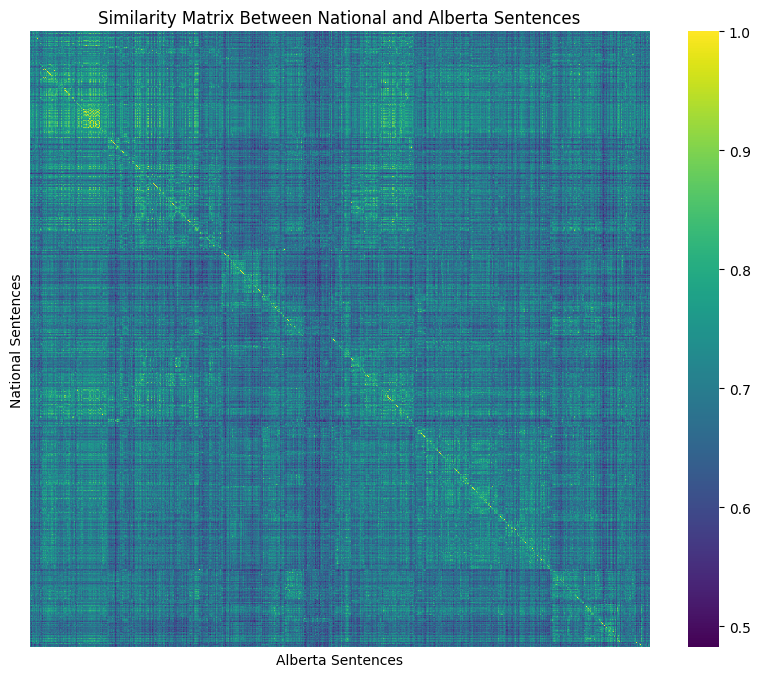

Similarity matrix computed and high-confidence matches saved!


In [12]:

# Encode using the custom function
national_embeddings = get_embeddings(national_sentences, model, tokenizer, batch_size=16)
alberta_embeddings = get_embeddings(alberta_sentences, model, tokenizer, batch_size=16)

# Convert embeddings to PyTorch tensors
national_embeddings_tensor = torch.tensor(national_embeddings, dtype=torch.float32)
alberta_embeddings_tensor = torch.tensor(alberta_embeddings, dtype=torch.float32)

batch_size = 1024  

# Function to compute cosine similarity in batches
def batched_cosine_similarity(national_emb, alberta_emb, batch_size):
    num_national = national_emb.shape[0]
    num_alberta = alberta_emb.shape[0]

    similarity_matrix = np.zeros((num_national, num_alberta), dtype=np.float32)

    for i in range(0, num_national, batch_size):
        batch_national = national_emb[i : i + batch_size]
        batch_national = batch_national.unsqueeze(1)  # Shape (batch_size, 1, embedding_dim)
        
        for j in range(0, num_alberta, batch_size):
            batch_alberta = alberta_emb[j : j + batch_size]
            batch_alberta = batch_alberta.unsqueeze(0)  # Shape (1, batch_size, embedding_dim)

            # Compute cosine similarity
            batch_similarity = F.cosine_similarity(batch_national, batch_alberta, dim=-1)

            # Store results
            similarity_matrix[i : i + batch_size, j : j + batch_size] = batch_similarity.cpu().numpy()

    return similarity_matrix

# Compute similarity matrix in batches
similarity_matrix_np = batched_cosine_similarity(national_embeddings_tensor, alberta_embeddings_tensor, batch_size)

print("Similarity matrix computed successfully!")

# Create a heatmap for visualization
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix_np, cmap="viridis", xticklabels=False, yticklabels=False)
plt.title("Similarity Matrix Between National and Alberta Sentences")
plt.xlabel("Alberta Sentences")
plt.ylabel("National Sentences")
plt.show()

# Extract high similarity matches
threshold = 0.8  # Define a similarity threshold
matched_sentences = []

for i, nat_sentence in enumerate(national_sentences):
    for j, alb_sentence in enumerate(alberta_sentences):
        if similarity_matrix_np[i, j] >= threshold:
            matched_sentences.append([
                nat_sentence,
                alb_sentence,
                similarity_matrix_np[i, j]
            ])

# Save matched sentences to a CSV file
matched_df = pd.DataFrame(matched_sentences, columns=["National Sentence", "Alberta Sentence", "Similarity Score"])
matched_df.to_csv("similar_sentences.csv", index=False)

print("Similarity matrix computed and high-confidence matches saved!")